# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources (README.md file)
- Happy learning!

In [1]:
#Generic
import numpy as np
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta

# Viz mantra
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
%config Inlinebackend.figure_format = 'retina'
sns.set_context('poster')
sns.set(rc={'figure.figsize': (16., 9.)})
sns.set_style('whitegrid')
from matplotlib import pyplot as plt

#Statsmodel
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse

# Challenge 1 - Loading and Evaluating The Data

In this lab, we will look at a dataset of sensor data from a cellular phone. The phone was carried in the subject's pocket for a few minutes while they walked around.

To load the data, run the code below.

In [2]:
# Run this code:

sensor = pd.read_csv('../sub_1.csv')
sensor.drop(columns=['Unnamed: 0'], inplace=True)

Examine the data using the `head` function.

In [3]:
sensor.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


Check whether there is any missing data. If there is any missing data, remove the rows containing missing data.

In [4]:
sensor.isna().sum()

attitude.roll         0
attitude.pitch        0
attitude.yaw          0
gravity.x             0
gravity.y             0
gravity.z             0
rotationRate.x        0
rotationRate.y        0
rotationRate.z        0
userAcceleration.x    0
userAcceleration.y    0
userAcceleration.z    0
dtype: int64

How many rows and columns are in our data?

In [5]:
print(f"It has {sensor.shape[0]} rows and {sensor.shape[1]} columns")

It has 1751 rows and 12 columns


To perform time series analysis on the data, we must change the index from a range index to a time series index. In the cell below, create a time series index using the `pd.date_range` function. Create a time series index starting at 1/1/2018 00:00:00 and ending at 1/1/2018 00:29:10. The number of periods is equal to the number of rows in `sensor`. The frequency should be set to `infer`.

In [6]:
indx = pd.date_range(start='2018-1-1 00:00:00', end = '2018-1-1 00:29:10', periods = sensor.shape[0])
indx

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 00:00:01',
               '2018-01-01 00:00:02', '2018-01-01 00:00:03',
               '2018-01-01 00:00:04', '2018-01-01 00:00:05',
               '2018-01-01 00:00:06', '2018-01-01 00:00:07',
               '2018-01-01 00:00:08', '2018-01-01 00:00:09',
               ...
               '2018-01-01 00:29:01', '2018-01-01 00:29:02',
               '2018-01-01 00:29:03', '2018-01-01 00:29:04',
               '2018-01-01 00:29:05', '2018-01-01 00:29:06',
               '2018-01-01 00:29:07', '2018-01-01 00:29:08',
               '2018-01-01 00:29:09', '2018-01-01 00:29:10'],
              dtype='datetime64[ns]', length=1751, freq=None)

In [7]:
indx.freq = pd.infer_freq(indx)

In [8]:
print(indx.freq)

<Second>


In [9]:
indx

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 00:00:01',
               '2018-01-01 00:00:02', '2018-01-01 00:00:03',
               '2018-01-01 00:00:04', '2018-01-01 00:00:05',
               '2018-01-01 00:00:06', '2018-01-01 00:00:07',
               '2018-01-01 00:00:08', '2018-01-01 00:00:09',
               ...
               '2018-01-01 00:29:01', '2018-01-01 00:29:02',
               '2018-01-01 00:29:03', '2018-01-01 00:29:04',
               '2018-01-01 00:29:05', '2018-01-01 00:29:06',
               '2018-01-01 00:29:07', '2018-01-01 00:29:08',
               '2018-01-01 00:29:09', '2018-01-01 00:29:10'],
              dtype='datetime64[ns]', length=1751, freq='S')

Assign the time series index to the dataframe's index.

In [10]:
sensor.set_index(indx, inplace=True)

In [11]:
sensor.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
2018-01-01 00:00:00,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
2018-01-01 00:00:01,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2018-01-01 00:00:02,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
2018-01-01 00:00:03,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
2018-01-01 00:00:04,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


Our next step is to decompose the time series and evaluate the patterns in the data. Load the `statsmodels.api` submodule and plot the decomposed plot of `userAcceleration.x`. Set `freq=60` in the `seasonal_decompose` function. Your graph should look like the one below.

![time series decomposition](../images/tsa_decompose.png)

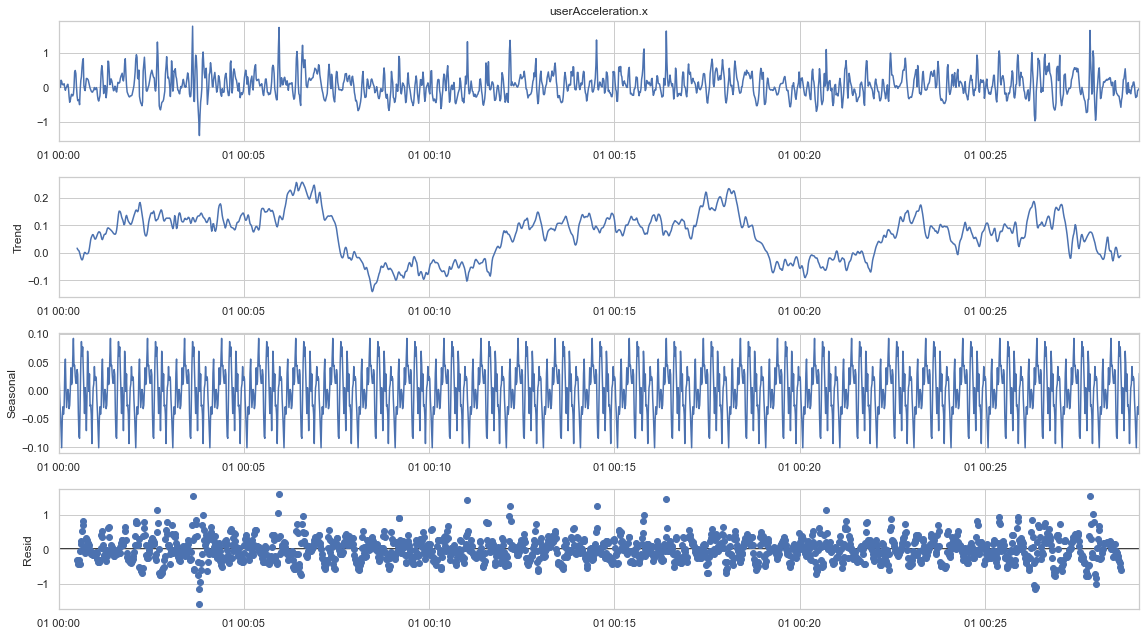

In [12]:
useracc = seasonal_decompose(sensor["userAcceleration.x"], model="additive", period=60)
useracc.plot();

Plot the decomposed time series of `rotationRate.x` also with a frequency of 60.

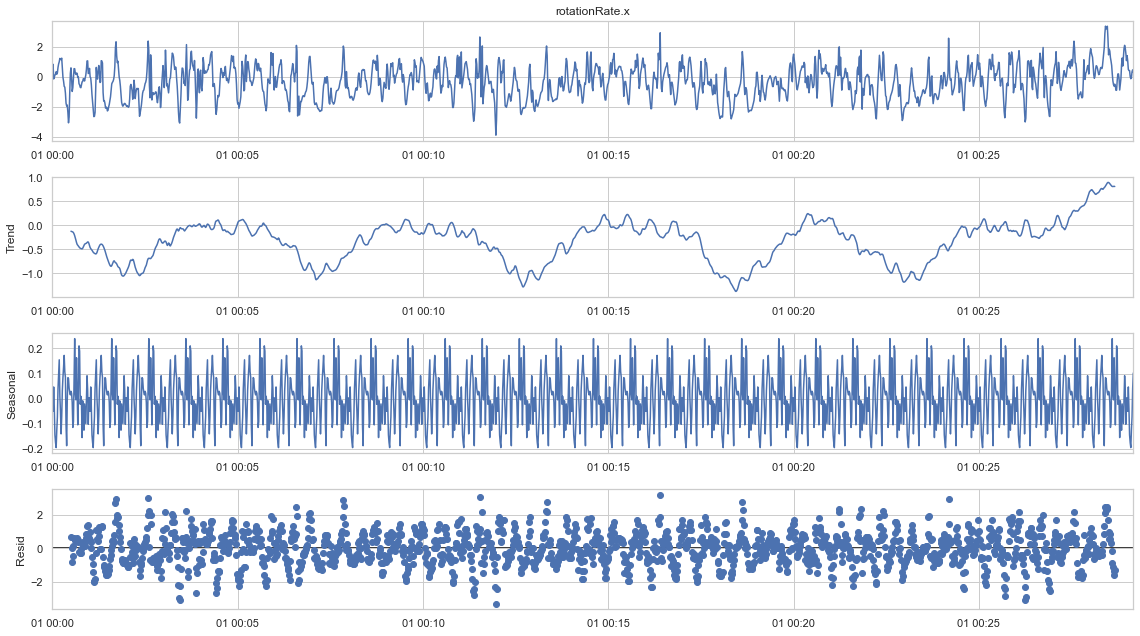

In [13]:
rotrat = seasonal_decompose(sensor["rotationRate.x"], model="additive", period=60)
rotrat.plot();

# Challenge 2 - Modelling the Data

To model our data, we should look at a few assumptions. First, let's plot the `lag_plot` to detect any autocorrelation. Do this for `userAcceleration.x`

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


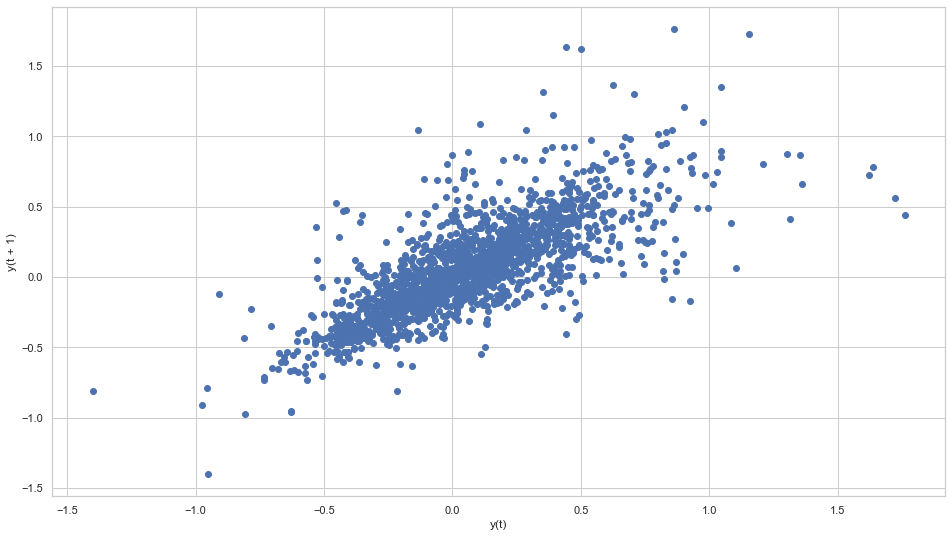

In [14]:
pd.plotting.lag_plot(sensor["userAcceleration.x"], lag=1);

Create a lag plot for `rotationRate.x`

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


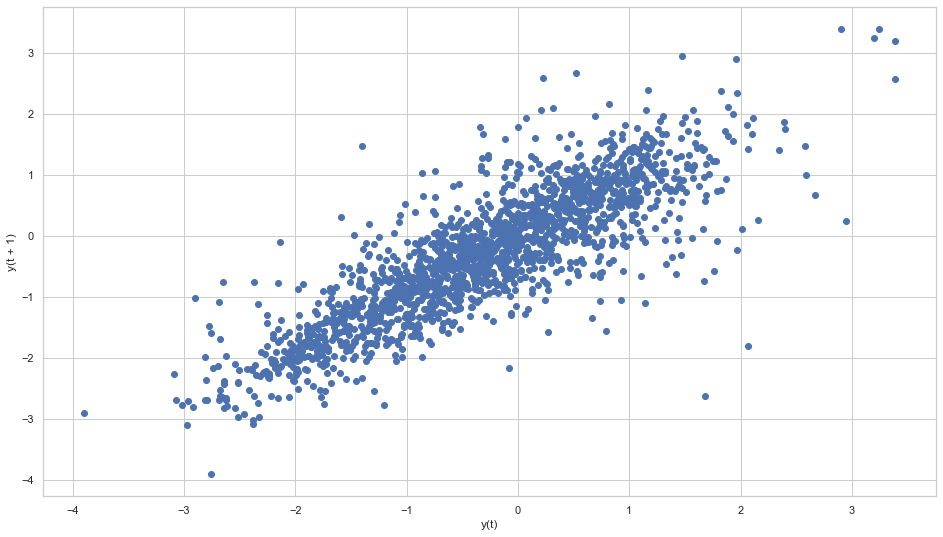

In [15]:
pd.plotting.lag_plot(sensor["rotationRate.x"], lag=1);

What are your conclusions from both visualizations?

**The Rotation Rate show more autocorrelation, because the scatter dots tend to follow a linear pattern. Therefore, if we have to make predictions based on the two variables, I think that an ARIMA model would fit better with the RotationRate rather than the UserAcceleration**

The next step will be to test both variables for stationarity. Perform the Augmented Dickey Fuller test on both variables below.

In [16]:
adfuseracc = adfuller(sensor["userAcceleration.x"])
print(f"The p-value is {adfuseracc[1]}")

The p-value is 2.823439483037483e-30


In [17]:
adfrotrat = adfuller(sensor["rotationRate.x"])
print(f"The p-value is {adfrotrat[1]}")

The p-value is 6.320230335911989e-06


What are your conclusions from this test?

In [18]:
if adfuseracc[1] > 0.05:
    print("userAcceleration.x --> We don't reject H0: it's not stationary")
elif adfuseracc[1] < 0.05:
    print("userAcceleration.x --> We reject H0: it's stationary")
if adfrotrat[1] > 0.05:
    print("rotationRate.x --> We don't reject H0: it's not stationary")
elif adfrotrat[1] < 0.05:
    print("rotationRate.x --> We reject H0: it's stationary")    

userAcceleration.x --> We reject H0: it's stationary
rotationRate.x --> We reject H0: it's stationary


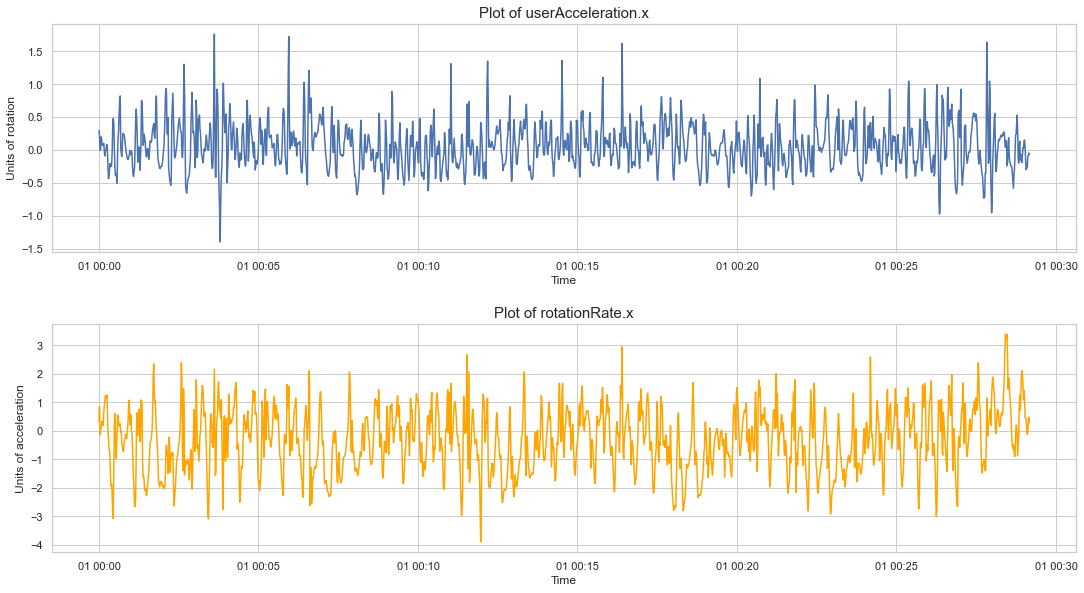

In [19]:
fig, ax = plt.subplots(2, 1)
fig.tight_layout(pad=4.0)

ax[0].plot(sensor["userAcceleration.x"])
ax[0].set_title("Plot of userAcceleration.x", fontsize=15)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Units of rotation")

ax[1].plot(sensor["rotationRate.x"], color="orange")
ax[1].set_title("Plot of rotationRate.x", fontsize=15)
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Units of acceleration");

**The adfuller tests demonstrate that both series of numbers follow a stationary pattern. It can be contrasted by plotting the values. In both cases, the numbers do not show any tendency: they lay on a basis line**

## Bonus: Challenge 2

Finally, we'll create an ARIMA model for `userAcceleration.x`. Load the `ARIMA` function from `statsmodels`. The order of the model is (2, 0, 1). Split the data to train and test. Use the last 10 observations as the test set and all other observations as the training set. 

In [20]:
# 0. Splitting into train & test
y_train = sensor["userAcceleration.x"][:-10]
y_test = sensor["userAcceleration.x"][-11:]

In [21]:
# 1. Create an instance of the ARIMA model that takes y_train, the order, and freq="S"
# Docs: https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima.model.ARIMA.html
model = ARIMA(y_train, order = (2, 0, 1), freq="S").fit()

In [22]:
# 2. Fit the model:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     userAcceleration.x   No. Observations:                 1741
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 373.401
Date:                Wed, 09 Nov 2022   AIC                           -736.803
Time:                        17:41:50   BIC                           -709.492
Sample:                    01-01-2018   HQIC                          -726.704
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0637      0.016      3.994      0.000       0.032       0.095
ar.L1          0.9882      0.036     27.630      0.000       0.918       1.058
ar.L2         -0.3788      0.033    -11.637      0.000      -0.443      -0.315
ma.L1          0.1824      0.039      4.643      0.000       0.105       0.259
sigma2         0.0381      0.001     46.070      0.000       0.036       0.040
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1776.70
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                             0.34
Prob(H) (two-sided):                  0.60   Kurtosis:                         7.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
# 3. Predict: create y_pred:

y_pred = model.predict(start=len(sensor)-10, end=len(sensor))

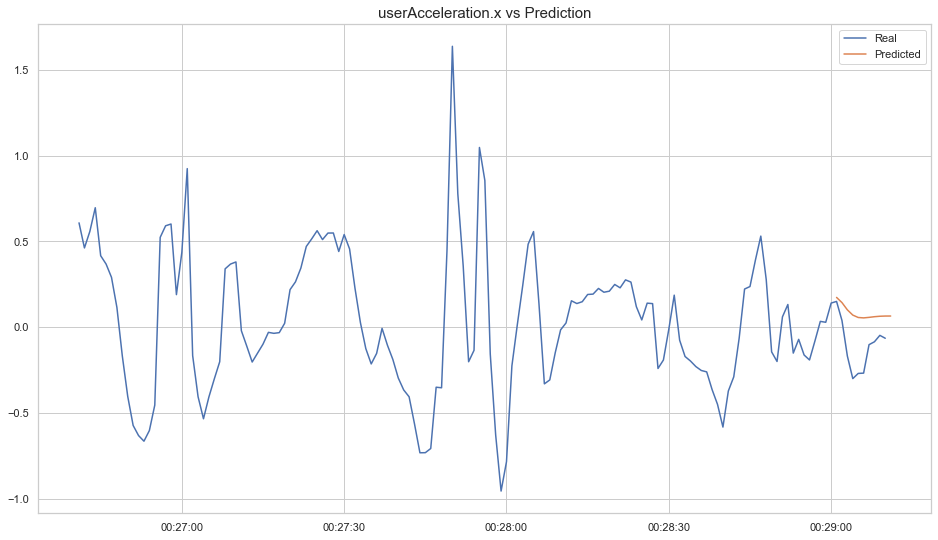

In [24]:
# 4. Visualize
plt.plot(sensor["userAcceleration.x"][-150:], label = "Real")
plt.plot(y_pred[-150:], label = "Predicted")
plt.title("userAcceleration.x vs Prediction",fontsize=15)
plt.legend();

**Now the last points in detail**

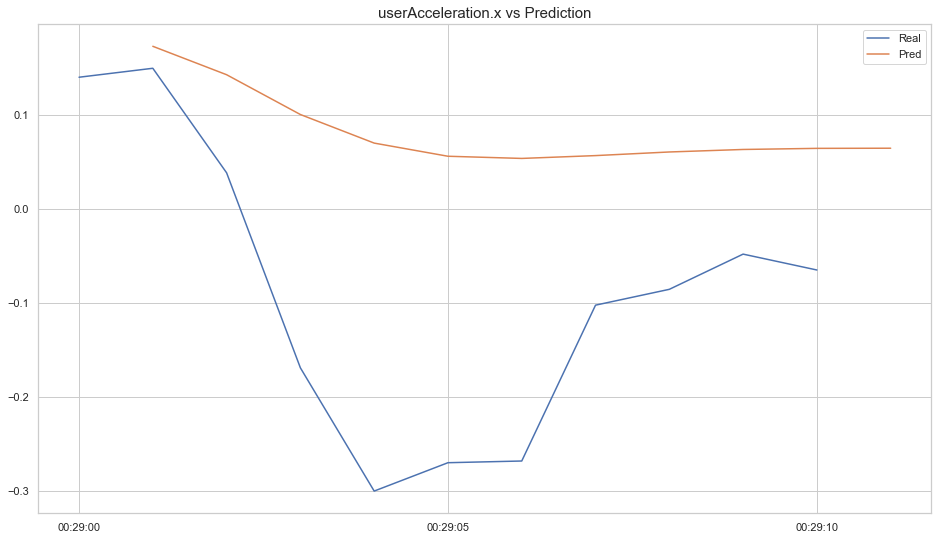

In [25]:
plt.plot(sensor["userAcceleration.x"][-11:], label = "Real")
plt.plot(y_pred[-11:], label = "Pred")
plt.title("userAcceleration.x vs Prediction",fontsize=15)
plt.legend();

To compare our predictions with the observed data, we can compute the RMSE (Root Mean Squared Error) from the submodule `statsmodels.tools.eval_measures`. You can read more about this function [here](https://www.statsmodels.org/dev/generated/statsmodels.tools.eval_measures.rmse.html). Compute the RMSE for the last 10 rows of the data by comparing the observed and predicted data for the `userAcceleration.x` column.

In [26]:
print(f"The RMSE is {rmse(y_pred, y_test)}")

The RMSE is 0.2085023469596755


**The error is quite big, as shown in the plot**

## BONUS of the BONUS, made up by me :)

**If the correlation is better with RotationRate, should the prediction be better?**

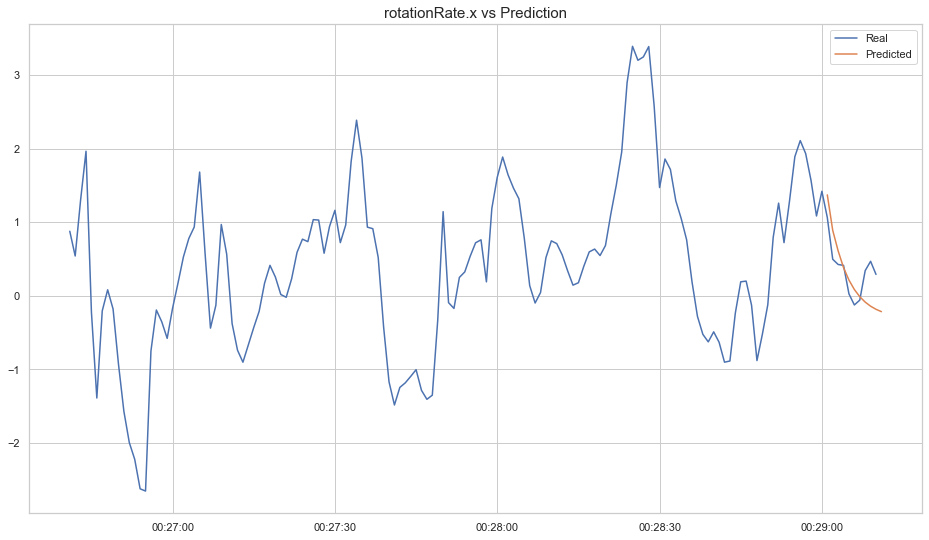

In [27]:
# Splitting into train & test
y_train = sensor["rotationRate.x"][:-10]
y_test = sensor["rotationRate.x"][-11:]
model = ARIMA(y_train, order = (2, 0, 1), freq="S").fit()
# Predict: create y_pred:
y_pred = model.predict(start=len(sensor)-10, end=len(sensor))
# Visualize
plt.plot(sensor["rotationRate.x"][-150:], label = "Real")
plt.plot(y_pred[-150:], label = "Predicted")
plt.title("rotationRate.x vs Prediction",fontsize=15)
plt.legend();

In [28]:
print(f"The RMSE is {rmse(y_pred, y_test)}")

The RMSE is 0.3043712479747392


**The prediction fits better!!**